# Finetuning lab

In order to finetune a model, one needs to know from the bottom. In this ipython notebook, try to make and understand every component used in the deep learning categories from scratch ; symbolic computing.

### TODO:
code implementation is in NCHW order. need to change for consistency.

## Contents
### chapter 1. [Information theory and Statistics lab](#Information theory and Statistics lab)  
### chapter 2. [ML-finetuning lab](#ML-finetuning lab)  
0. [Computational Graph and quick implementation](#Computational Graph and quick implementation)
1. [Weight Initialization and Activation](#Weight Initialization and Activation)
2. [Loss function](#Loss function)
3. [Building blocks](#Building blocks)
    - [BatchNormalization](#BatchNormalization)
    - [Convolutional Layer](#Convolutional Layer)
    - [Pooling](#Pooling)
    - Dropout
    - RNN
    - LSTM cell
    - GRU
4. [Optimization and update scheme](#Optimization and update scheme)
5. [ConvNet Model Breakdown](#ConvNet Model Breakdown)
    - Inception Module
    - ResNet Module
    
---

hw1    
understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)  
understand the train/val/test splits and the use of validation data for hyperparameter tuning.  
develop proficiency in writing efficient vectorized code with numpy  
implement and apply a k-Nearest Neighbor (kNN) classifier   
implement and apply a Multiclass Support Vector Machine (SVM) classifier  
implement and apply a Softmax classifier  
implement and apply a Two layer neural network classifier  
understand the differences and tradeoffs between these classifiers  
get a basic understanding of performance improvements from using higher-level representations than raw pixels   
(e.g. color histograms, Histogram of Gradient (HOG) features)  



hw2
understand Neural Networks and how they are arranged in layered architectures  
understand and be able to implement (vectorized) backpropagation  
implement various update rules used to optimize Neural Networks   
implement batch normalization for training deep networks  
implement dropout to regularize networks  
effectively cross-validate and find the best hyperparameters for Neural Network architecture  
understand the architecture of Convolutional Neural Networks and train gain experience with training these models on data  



### REFERENCE and TIPS and TRICKS


[cs231n homework](http://cs231n.github.io/) and [thorey github post](https://github.com/cthorey/CS231)

 watch Bias-Variance tradeoff  
 https://github.com/thomasj02/DeepLearningProjectWorkflow/blob/master/README.md   
 Loss function : Use CE  
 https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/  

https://github.com/beopst/tf-performance-tips


In [3]:
DATASET_DIR = './dataset/'
SUMMARY_DIR = './summaries/finetuning_lab/'
SAVER_DIR = './models/finetuning_lab/'

In [12]:
import numpy as np
import matplotlib.pyplot as plt

<a id='Information theory and Statistics lab'></a>
# chapter 1. Information Theory and Statistics lab

Entropy :  
discrete random variable X with $\{ x_1, ..., x_n \}$  
\begin{align}
H \left( X \right) = - \overset{n}{\underset{i=1}{\sum}} P \left( x_i \right) \log P \left( x_i \right)
\end{align}

properties of entropy
  - chain rule : $ H \left( X,Y \right) = H \left( Y|X \right) + H \left( X \right) $

Bayes Rule :
$P(H|e) = \frac{P(e|H) \cdot P(H)}{P(e)}$

Likelihood : $P(e|H)$  
Prior : $P(H)$  
Posterior : $P(H|e)$  
Marginal : $P(e)$  

KL divergence :  

  wiki says ".. measure of non-symmetric difference between two probability distribution P and Q. .. D_KL(P||Q) is a measure of the information gained when one revises one's beliefs from the prior probability distribution Q to the posterior probability distribution P. Amount of information lost when Q is used to approximate P .. not true metric .. infinitesimal form .. Hessian .. gives metric tensor known as the **Fisher information metric** .. " and '.. machine learning context : ** relative entropy ** of P with respect to Q and Coding Theory context : the expected number of extra bits required to code samples from P using code optimized for Q.. '

\begin{align}
D_{KL} \left( P || Q \right) = \sum_{i} P \left( i \right) \log \frac{P \left( i \right)}{Q \left( i \right)}
\end{align}


In short, $D_{KL}(P||Q)$  
  1. non-symmetric difference btw two probability distribution P and Q
  2. amount of information gained with Q with known P distribution.
  3. amount of information lost when Q to approximate P distribution.
  4. amount of information gained if P is used instead of Q
  
  
Mutual Information :  
  
\begin{align}
I \left( X ; Y \right) = \underset{y \in Y}{\sum} \underset{x \in X}{\sum} p \left( x,y \right) \log \frac{p \left( x, y \right)}{p \left( x \right) p \left( y \right)} = D_{KL} \left( p \left( x,y \right) || p \left( x \right) p \left( y \right) \right)
\end{align}

properties of mutual information
  - $ I \left( X,Y \right) = H \left( X \right) - H \left( X|Y \right) = H \left( Y \right) - H \left( Y|X \right)$

<a id='ML-finetuning lab'></a>
# chapter 2. ML-finetuning lab

In [6]:
from dataset.data_utils import *

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
#from cs231n.classifiers.fc_net import *
#from cs231n.data_utils import get_CIFAR10_data
#from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
#from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [70]:
from keras.datasets import cifar10
dataset = cifar10.load_data()
train = dataset[0]
test = dataset[1]

data = {
    'X_val' : train[0][:1000].astype(np.float32), 
    'X_train' : train[0][1000:].astype(np.float32),
    'y_val' : train[1][:1000],
    'y_train' : train[1][1000:],
    'X_test' : test[0].astype(np.float32),
    'y_test' : test[1]
}

for k, v in data.items():
    print('%s: ' % k, v.shape)


y_test:  (10000, 1)
X_train:  (49000, 32, 32, 3)
y_train:  (49000, 1)
X_val:  (1000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
y_val:  (1000, 1)


<a id='Computational Graph and quick implementation'></a>
## 0. Computational Graph and quick implementation

#### numpy
#### cf https://github.com/mnielsen/neural-networks-and-deep-learning, http://neuralnetworksanddeeplearning.com/

In [ ]:
import numpy as np

class ComputationalGraph(object):
    def forward(inputs):
        for gate in self.graph.nodes_topologically_sorted():
            gate.forward()
        return loss
    def backward():
        for gate in reversed(self.graph.nodes_topologically_sorted()):
            gate.backward()
        return inputs_gradients
    def run():
        while True:
            

class two_scalar_ops(object):
    """ for two scalar variable inputs """
    def forward(x, y):
        return 
    def backward(x, y):
        return 


class MultiplyGate(two_scalar_ops):
    def forward(x, y):
        z = x*y
        self.x = x
        self.y = y
        return z
    def backward(dz):
        dx = self.y*dz
        dy = self.x*dz
        return [dx, dy]


class SigmoidGate(ops):
    def forward(x):
        z = 1. / 1. + np.exp(-x)
        self.x = x
        return z
    def backward(dz):
        dx = self.forward(x)*(1-self.forward(x))*dz
        return [dx]        

In [19]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        
        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval
        
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.
    
    We assume that f accepts several input blobs as arguments, followed by a blob
    into which outputs will be written. For example, f might be called like this:

    f(x, w, out)
    
    where x and w are input Blobs, and the result of f will be written to out.

    Inputs: 
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                                     op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig
            
            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                            inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in xrange(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### tensorflow for designated graph

#### cf http://blog.aloni.org/posts/backprop-with-tensorflow/

In [20]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(DATASET_DIR+'MNIST_data', one_hot=True)

a_0 = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

n_hidden = 30
w_1 = tf.Variable(tf.truncated_normal([784, n_hidden]))
b_1 = tf.Variable(tf.truncated_normal([1, n_hidden]))
w_2 = tf.Variable(tf.truncated_normal([n_hidden, 10]))
b_2 = tf.Variable(tf.truncated_normal([1, 10]))

def sigmoid(x):
    return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

def sigmoid_der(x):
    return tf.multiply(sigmoid(x), tf.subtract(tf.constant(1.0), sigmoid(x)))

z_1 = tf.add(tf.matmul(a_0, w_1), b_1)
a_1 = sigmoid(z_1)
z_2 = tf.add(tf.matmul(a_1, w_2), b_2)
pred = sigmoid(z_2)

loss = tf.subtract(pred, y)

# Backward propagation
d_z_2 = tf.multiply(loss, sigmoid_der(z_2))
d_b_2 = d_z_2
d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)

d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
d_z_1 = tf.multiply(d_a_1, sigmoid_der(z_1))
d_b_1 = d_z_1
d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)s

# updating network
learning_rate = tf.constant(0.5)
trainer_step = [
    tf.assign(w_1, tf.subtract(w_1, tf.multiply(learning_rate, d_w_1))),
    tf.assign(b_1, tf.subtract(b_1, tf.multiply(learning_rate, tf.reduce_mean(d_b_1, axis=[0])))),
    tf.assign(w_2, tf.subtract(w_2, tf.multiply(learning_rate, d_w_2))),
    tf.assign(b_2, tf.subtract(b_2, tf.multiply(learning_rate, tf.reduce_mean(d_b_2, axis=[0]))))
]

# wrap 1:
# vars_ = tf.get_collections(tf.GraphKeys.TRAINABLE_VARIABLES, name_scope=None)
# grads = tf.compute_gradients(vars_)
# trainer_step = tf.apply_gradients(vars_, grads)

# wrap 2:
# trainer_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=None)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        batch_xs, batch_ys = mnist.train.next_batch(10)
        sess.run(trainer_step, feed_dict={a_0: batch_xs, y: batch_ys})
        if i % 1000 == 0:
            print(sess.run(accuracy, feed_dict={a_0: mnist.test.images[:100], y:mnist.test.labels[:100]}))
        

Extracting ./dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
0.12
0.81
0.91
0.91
0.95
0.91
0.93
0.95
0.96
0.97


<a id='Weight Initialization and Activation'></a>
## 1. Weight Initialization and Activation

 Understanding the difficulty of training deep feedforward neural networks, Glorot and Bengio, 2010.  
 Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification, He et al., 2015.  
 Data-dependent Initializations of Convolutional Neural Networks, Krahenbuhl et al., 2015  

[INPUT LAYER] Mean : 0.0010 and Standard Deviation : 0.9997
[HIDDEN LAYER 1] Mean : -0.0016, Standard Deviatoin : 0.7203
[HIDDEN LAYER 2] Mean : 0.0007, Standard Deviatoin : 0.6334
[HIDDEN LAYER 3] Mean : -0.0004, Standard Deviatoin : 0.5954
[HIDDEN LAYER 4] Mean : -0.0010, Standard Deviatoin : 0.5758
[HIDDEN LAYER 5] Mean : -0.0003, Standard Deviatoin : 0.5674
[HIDDEN LAYER 6] Mean : -0.0006, Standard Deviatoin : 0.5621
[HIDDEN LAYER 7] Mean : 0.0001, Standard Deviatoin : 0.5587
[HIDDEN LAYER 8] Mean : 0.0001, Standard Deviatoin : 0.5581
[HIDDEN LAYER 9] Mean : 0.0004, Standard Deviatoin : 0.5574
[HIDDEN LAYER 10] Mean : -0.0006, Standard Deviatoin : 0.5574


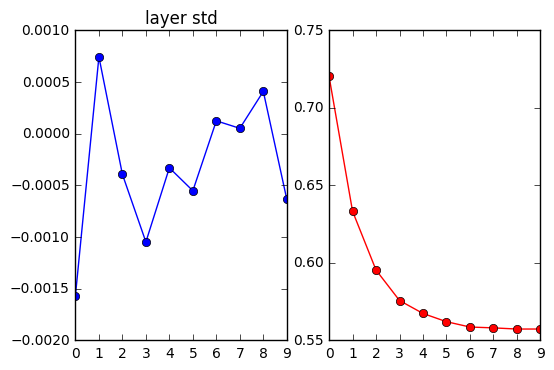

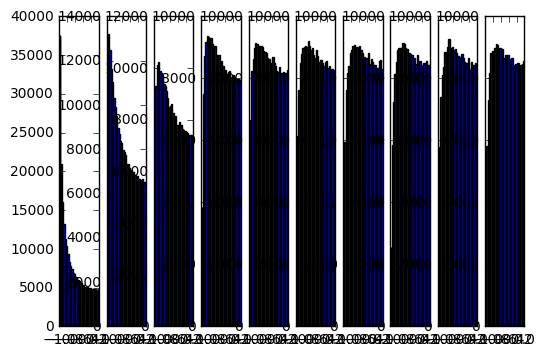

In [4]:
# Weight Histogram Plot
def weights_lab():
    layer_depth = 10
    input_dim = 1000
    hidden_dim = 500

    D = np.random.randn(input_dim, hidden_dim)
    hidden_layer_sizes = [hidden_dim]*layer_depth
    nonlinearities = ['tanh']*len(hidden_layer_sizes) # for now set all same activation
    stddev=.01

    activation_fn = {
        'relu':lambda x: np.maximum(0, x), 
        'lrelu':lambda x: np.maximum(0.1*x, x),
        'tanh':lambda x: np.tanh(x),
        }

    def xavier_initializer(shape):
        """ Glorot et al. 2010 ; assumed :linear activation:
            NOTE: tanh works reasonable but not on relu
         """
        #return np.random.normal(size=shape, scale=1/shape[0])
        return np.random.randn(shape[0], shape[1]) / np.sqrt(shape[0])

    def he_initializer(shape):
        """ He et al. 2015 ; additional 1/2
            NOTE: on relu
        """
        #return np.random.normal(size=shape, scale=1/shape[0])
        return np.random.randn(shape[0], shape[1]) / np.sqrt(shape[0]/2.)

    Hs = {}

    for i in range(len(hidden_layer_sizes)):
        X = D if i == 0 else Hs[i-1]#put before layer
        fan_in = X.shape[1]
        fan_out = hidden_layer_sizes[i]
        #W = np.random.randn(fan_in, fan_out)*stddev
        #W = xavier_initializer([fan_in, fan_out])
        W = he_initializer([fan_in,fan_out])
        H = np.dot(X, W)
        H = activation_fn[nonlinearities[i]](H)
        Hs[i] = H

    print("[INPUT LAYER] Mean : {:.4f} and Standard Deviation : {:.4f}".format(np.mean(D), np.std(D)))
    layer_means = [np.mean(H) for idx, H in Hs.items()]
    layer_stds = [np.std(H) for idx, H in Hs.items()]
    for idx, H in Hs.items():
        print("[HIDDEN LAYER {:d}] Mean : {:.4f}, Standard Deviatoin : {:.4f}".format(idx+1, 
                            layer_means[idx], layer_stds[idx]))

    plt.figure()
    plt.subplot(121)
    plt.title('layer mean')
    plt.plot(list(Hs.keys()), layer_means, 'ob-')
    plt.title('layer std')
    plt.subplot(122)
    plt.plot(list(Hs.keys()), layer_stds, 'or-')
    plt.figure()
    for idx, H in Hs.items():
        plt.subplot(1, len(Hs), idx+1)
        plt.hist(H.ravel(), 30, range(-1,1))
    plt.show()
weights_lab()

In [ ]:
class Activation(object):
    def relu_forward(x):
        """
        Computes the forward pass for a layer of rectified linear units (ReLUs).

        Input:
        - x: Inputs, of any shape

        Returns a tuple of:
        - out: Output, of the same shape as x
        - cache: x
        """

        out = np.maximum(0, x)
        cache = x

        return out, cache


    def relu_backward(dout, cache):
        """
        Computes the backward pass for a layer of rectified linear units (ReLUs).

        Input:
        - dout: Upstream derivatives, of any shape
        - cache: Input x, of same shape as dout

        Returns:
        - dx: Gradient with respect to x
        """

        x = cache
        dx = np.array(dout, copy=True)
        dx[x <= 0] = 0

        return dx

<a id='Loss function'></a>
## 2. Loss function

In [ ]:
def loss_lab():
    """ Square L2 L1 L0 SVM CE
    """
    def svm_loss(s_j, s_yi):
        return np.max(0, s_j - s_yi + 1).sum()

    def svm_loss(x, y):
        """
        Computes the loss and gradient using for multiclass SVM classification.

        Inputs:
        - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
          for the ith input.
        - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
          0 <= y[i] < C

        Returns a tuple of:
        - loss: Scalar giving the loss
        - dx: Gradient of the loss with respect to x
        """
        N = x.shape[0]
        correct_class_scores = x[np.arange(N), y]
        margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
        margins[np.arange(N), y] = 0
        loss = np.sum(margins) / N
        num_pos = np.sum(margins > 0, axis=1)
        dx = np.zeros_like(x)
        dx[margins > 0] = 1
        dx[np.arange(N), y] -= num_pos
        dx /= N
        return loss, dx

    def softmax_loss(x, y):
        """
        Computes the loss and gradient for softmax classification.

        Inputs:
        - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
          for the ith input.
        - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
          0 <= y[i] < C

        Returns a tuple of:
        - loss: Scalar giving the loss
        - dx: Gradient of the loss with respect to x
        """
        probs = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        N = x.shape[0]
        loss = -np.sum(np.log(probs[np.arange(N), y])) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx

    def cross_entropy():
        return 

<a id='Building blocks'></a>
## 3. Building blocks
  - [BatchNormalization](#BatchNormalization)
  - [Convolutional Layer](#Convolutional Layer)
  - [SpatialBatchNormalization](#SpatialBatchNormalization)
  - [Pooling](#Pooling)
  - [Dropout](#Dropout)
  - Im2Col method
  - [RNN](#RNN)
  - LSTM cell
  - GRU

In [ ]:
# https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb
class GuidedBackpropagation():

<a id='BatchNormalization'></a>
### BatchNormalization
** Notation **   
$f$ : Index of the **f**eature dimension (size $H$ : **h**idden)  
$m$ : Index of the **m**ini-batch data (size $N$ : **n**umber)  
$\mathcal{B}$ : variable on mini-batch

#### In forward pass

\begin{align}
{}_{\mathcal{B}}\mu_f \leftarrow \overset{N}{\underset{m=1}{\sum}} x_{mf} \\
{}_{\mathcal{B}}\sigma_f^2 \leftarrow \overset{N}{\underset{m=1}{\sum}} \left( x_{mf} - {}_{\mathcal{B}}\mu_f \right)^2 \\
\hat{x}_{mf} = \frac{ x_{mf} - {}_{\mathcal{B}}\mu_f }{\sqrt{{}_{\mathcal{B}}\sigma_f^2 + \epsilon}}\\
y_{mf} \leftarrow \gamma_f \hat{x}_{mf} + \beta_f
\end{align}


#### In backward pass : calculate local gradient

\begin{eqnarray}
%1
\frac{\partial L}{\partial \hat{x}_{mf}} &=& 
\overset{N}{\underset{m' = 1}{\sum}} \frac{\partial L}{\partial y_{m'f}} \cdotp
\frac{\partial y_{m'f}}{\partial \hat{x}_{mf}} =
\frac{\partial L}{\partial y_{mf}} \gamma_f \\
%2
\frac{\partial L}{\partial \gamma_f} &=& 
\overset{N}{\underset{m = 1}{\sum}} \frac{\partial L}{\partial y_{mf}} \cdotp
\frac{\partial y_{mf}}{\partial \gamma_f} =
\overset{N}{\underset{m = 1}{\sum}} \frac{\partial L}{\partial y_{mf}} \hat{x}_{mf} \\
%3
\frac{\partial L}{\partial \beta_f} &=&  
\overset{N}{\underset{m = 1}{\sum}} \frac{\partial L}{\partial y_{mf}} \cdotp 
\frac{\partial y_{mf}}{\partial \beta_f} =
\overset{N}{\underset{m=1}{\sum}} \frac{\partial L}{\partial y_{mf}} \\
%4
\frac{\partial L}{\partial {}_{\mathcal{B}}\sigma_f^2} &=& 
\underset{m=1}{\overset{N}{\sum}} \frac{\partial L}{\partial \hat{x}_{mf}} \cdotp
\frac{\partial \hat{x}_{mf}}{\partial {}_{\mathcal{B}}\sigma_f^2} =
\underset{m=1}{\overset{N}{\sum}} \frac{\partial L}{\partial \hat{x}_{mf}} \cdotp
\frac{x_{mf} - {}_{\mathcal{B}}\mu_f}{-2 \left( {}_{\mathcal{B}} \sigma_f^2 + \epsilon \right)^{-\frac{3}{2}}} \\
% dL/dmu
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_f} &=& 
\overset{N}{\underset{m = 1}{\sum}} \frac{\partial L}{\partial \hat{x}_{mf}} \cdotp 
\left(
\frac{\partial \hat{x}_{mf}}{\partial {}_{\mathcal{B}}\mu_f} +
\frac{\partial \hat{x}_{mf}}{\partial {}_{\mathcal{B}}\sigma_f^2} \cdotp
\frac{\partial {}_{\mathcal{B}}\sigma_f^2}{\partial {}_{\mathcal{B}}\mu_f}
\right)\\
&=& 
\underset{m=1}{\overset{N}{\sum}} \frac{\partial L}{\partial \hat{x}_{mf}} \cdotp
\left(- \frac{1}{\sqrt{{}_{\mathcal{B}}\sigma_f^2 + \epsilon }}\right)
+ \frac{\partial L}{\partial {}_{\mathcal{B}}\sigma_f^2} \cdotp
\frac{\underset{m=1}{\overset{N}{\sum}}-2 \left( x_{mf}-{}_{\mathcal{B}}\mu_f\right) }{N} \\
% dL/dx
\frac{\partial L}{\partial x_{mf}} &=& 
\left( 
\underset{m'=1}{\overset{N}{\sum}} 
\frac{\partial L}{\partial \hat{x}_{m'f}} \cdotp
\frac{\partial \hat{x}_{m'f}}{\partial x_{mf}} \right) +
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_f} \cdotp
\frac{\partial {}_{\mathcal{B}}\mu_f}{\partial x_{mf}} + 
\frac{\partial L}{\partial {}_{\mathcal{B}} \sigma_f^2} \cdotp
\frac{\partial {}_{\mathcal{B}}\sigma_f^2}{\partial x_{mf}} \\
&=&
\frac{\partial L}{\partial \hat{x}_{mf}} \cdotp
\frac{1}{\sqrt{{}_{\mathcal{B}}\sigma_f^2 + \epsilon}} + 
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_f} \cdotp
\frac{1}{N} +
\frac{\partial L}{{}_{\mathcal{B}}\sigma_f^2} \cdotp
\frac{2 \left( x_{mf} - {}_{\mathcal{B}}\sigma_f^2 \right)}{N}
\end{eqnarray}

#### In backward pass : calculate through top
First, we have:
$$ \frac{dy_{kl}}{d\hat{x}_{kl}} = \gamma_l$$
and
\begin{eqnarray}
\frac{d\hat{x}_{kl}}{dx_{ij}} = (\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{2}(x_{kl}-\mu_l)\frac{d\sigma_l^2}{dx_{ij}}(\sigma_l^2+\epsilon)^{-3/2}
\end{eqnarray}
where 
$$\sigma_l^2 = \frac{1}{N}\sum_p \left(x_{pl}-\mu_l\right)^2$$
and then,
\begin{eqnarray}
\frac{d\sigma_l^2}{dx_{ij}} &=& \frac{1}{N}\sum_p2\left(\delta_{ip}\delta_{jl}-\frac{1}{N}\delta_{jl}\right)\left(x_{pl}-\mu_l\right)\\
&=&\frac{2}{N}(x_{il}-\mu_l)\delta_{jl}-\frac{2}{N^2}\sum_p\delta_{jl}\left(x_{pl}-\mu_l\right)\\
&=& \frac{2}{N}(x_{il}-\mu_l)\delta_{jl}
\end{eqnarray}

Putting everything together we thus have
\begin{eqnarray}
\frac{d\hat{x}_{kl}}{dx_{ij}} = (\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}
\end{eqnarray}

and therefore

\begin{eqnarray}
\frac{dL}{dx_{ij}} &=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{d\hat{x}_{kl}}\frac{d\hat{x}_{kl}}{dx_{ij}}\\
&=& \sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left((\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}\right)\\
&=&\sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left((\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}\right)-\sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left(\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}\right)\\
&=&\frac{dL}{dy_{ij}}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}-\frac{1}{N}\sum_{k}\frac{dL}{dy_{kj}}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}-\frac{1}{N}\sum_{k}\frac{dL}{dy_{kj}}\gamma_j\left((x_{kj}-\mu_j)(x_{ij}-\mu_j)(\sigma_j^2+\epsilon)^{-3/2}\right)\\
&=&\frac{1}{N}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}\left(N\frac{dL}{dy_{ij}}-\sum_k\frac{dL}{dy_{kj}}-(x_{ij}-\mu_j)(\sigma_j^2+\epsilon)^{-1}\sum_k\frac{dL}{dy_{kj}}(x_{kj}-\mu_j)\right)
\end{eqnarray}



#### Question 
okay, how does this fix the covariance shift?   
enable higher learning rate, regularization?  

In [63]:
class BatchNormalization(object):
    def forward(self, x, gamma, beta, bn_param):
        """
        Forward pass for batch normalization.

        During training the sample mean and (uncorrected) sample variance are
        computed from minibatch statistics and used to normalize the incoming data.
        During training we also keep an exponentially decaying running mean of the mean
        and variance of each feature, and these averages are used to normalize data
        at test-time.

        At each timestep we update the running averages for mean and variance using
        an exponential decay based on the momentum parameter:

        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var

        Note that the batch normalization paper suggests a different test-time
        behavior: they compute sample mean and variance for each feature using a
        large number of training images rather than using a running average. For
        this implementation we have chosen to use running averages instead since
        they do not require an additional estimation step; the torch7 implementation
        of batch normalization also uses running averages.

        Input:
        - x: Data of shape (N, D)
        - gamma: Scale parameter of shape (D,)
        - beta: Shift paremeter of shape (D,)
        - bn_param: Dictionary with the following keys:
          - mode: 'train' or 'test'; required
          - eps: Constant for numeric stability
          - momentum: Constant for running mean / variance.
          - running_mean: Array of shape (D,) giving running mean of features
          - running_var Array of shape (D,) giving running variance of features

        Returns a tuple of:
        - out: of shape (N, D)
        - cache: A tuple of values needed in the backward pass
        """
        mode = bn_param['mode']
        eps = bn_param.get('eps', 1e-5)
        momentum = bn_param.get('momentum', 0.9)

        N, D = x.shape
        running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
        running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

        out, cache = None, None
        if mode == 'train':
            #######################################################################
            # TODO: Implement the training-time forward pass for batch normalization.   #
            # Use minibatch statistics to compute the mean and variance, use these      #
            # statistics to normalize the incoming data, and scale and shift the        #
            # normalized data using gamma and beta.                                     #
            #                                                                           #
            # You should store the output in the variable out. Any intermediates that   #
            # you need for the backward pass should be stored in the cache variable.    #
            #                                                                           #
            # You should also use your computed sample mean and variance together with  #
            # the momentum variable to update the running mean and running variance,    #
            # storing your result in the running_mean and running_var variables.        #
            #######################################################################

            # Forward pass
            # Step 1 - shape of mu (D,)
            mu = 1 / float(N) * np.sum(x, axis=0)

            # Step 2 - shape of var (N,D)
            xmu = x - mu

            # Step 3 - shape of carre (N,D)
            carre = xmu**2

            # Step 4 - shape of var (D,)
            var = 1 / float(N) * np.sum(carre, axis=0)

            # Step 5 - Shape sqrtvar (D,)
            sqrtvar = np.sqrt(var + eps)

            # Step 6 - Shape invvar (D,)
            invvar = 1. / sqrtvar

            # Step 7 - Shape va2 (N,D)
            va2 = xmu * invvar

            # Step 8 - Shape va3 (N,D)
            va3 = gamma * va2

            # Step 9 - Shape out (N,D)
            out = va3 + beta

            running_mean = momentum * running_mean + (1.0 - momentum) * mu
            running_var = momentum * running_var + (1.0 - momentum) * var

            cache = (mu, xmu, carre, var, sqrtvar, invvar,
                     va2, va3, gamma, beta, x, bn_param)
        elif mode == 'test':
            #######################################################################
            # TODO: Implement the test-time forward pass for batch normalization. Use   #
            # the running mean and variance to normalize the incoming data, then scale  #
            # and shift the normalized data using gamma and beta. Store the result in   #
            # the out variable.                                                         #
            #######################################################################
            mu = running_mean
            var = running_var
            xhat = (x - mu) / np.sqrt(var + eps)
            out = gamma * xhat + beta
            cache = (mu, var, gamma, beta, bn_param)

        else:
            raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

        # Store the updated running means back into bn_param
        bn_param['running_mean'] = running_mean
        bn_param['running_var'] = running_var

        return out, cache


    def backward(self, dout, cache):
        """
        Backward pass for batch normalization.

        For this implementation, you should write out a computation graph for
        batch normalization on paper and propagate gradients backward through
        intermediate nodes.

        Inputs:
        - dout: Upstream derivatives, of shape (N, D)
        - cache: Variable of intermediates from batchnorm_forward.

        Returns a tuple of:
        - dx: Gradient with respect to inputs x, of shape (N, D)
        - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
        - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
        """
        dx, dgamma, dbeta = None, None, None

        ##########################################################################
        # TODO: Implement the backward pass for batch normalization. Store the      #
        # results in the dx, dgamma, and dbeta variables.                           #
        ##########################################################################
        mu, xmu, carre, var, sqrtvar, invvar, va2, va3, gamma, beta, x, bn_param = cache
        eps = bn_param.get('eps', 1e-5)
        N, D = dout.shape

        # Backprop Step 9
        dva3 = dout
        dbeta = np.sum(dout, axis=0)

        # Backprop step 8
        dva2 = gamma * dva3
        dgamma = np.sum(va2 * dva3, axis=0)

        # Backprop step 7
        dxmu = invvar * dva2
        dinvvar = np.sum(xmu * dva2, axis=0)

        # Backprop step 6
        dsqrtvar = -1. / (sqrtvar**2) * dinvvar

        # Backprop step 5
        dvar = 0.5 * (var + eps)**(-0.5) * dsqrtvar

        # Backprop step 4
        dcarre = 1 / float(N) * np.ones((carre.shape)) * dvar

        # Backprop step 3
        dxmu += 2 * xmu * dcarre

        # Backprop step 2
        dx = dxmu
        dmu = - np.sum(dxmu, axis=0)

        # Basckprop step 1
        dx += 1 / float(N) * np.ones((dxmu.shape)) * dmu

        return dx, dgamma, dbeta


    def backward_alt(self, dout, cache):
        """
        Alternative backward pass for batch normalization.

        For this implementation you should work out the derivatives for the batch
        normalizaton backward pass on paper and simplify as much as possible. You
        should be able to derive a simple expression for the backward pass.

        Note: This implementation should expect to receive the same cache variable
        as batchnorm_backward, but might not use all of the values in the cache.

        Inputs / outputs: Same as batchnorm_backward
        """
        dx, dgamma, dbeta = None, None, None

        ##########################################################################
        # TODO: Implement the backward pass for batch normalization. Store the      #
        # results in the dx, dgamma, and dbeta variables.                           #
        #                                                                           #
        # After computing the gradient with respect to the centered inputs, you     #
        # should be able to compute gradients with respect to the inputs in a       #
        # single statement; our implementation fits on a single 80-character line.  #
        ##########################################################################
        mu, xmu, carre, var, sqrtvar, invvar, va2, va3, gamma, beta, x, bn_param = cache
        eps = bn_param.get('eps', 1e-5)
        N, D = dout.shape

        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum((x - mu) * (var + eps)**(-1. / 2.) * dout, axis=0)
        dx = (1. / N) * gamma * (var + eps)**(-1. / 2.) * (N * dout - np.sum(dout, axis=0)
                                                           - (x - mu) * (var + eps)**(-1.0) * np.sum(dout * (x - mu), axis=0))

        return dx, dgamma, dbeta


    def test(self, bn_param):
        mode = bn_param['mode']
        if mode == 'train':
            # Check the training-time forward pass by checking means and variances
            # of features both before and after batch normalization

            # Simulate the forward pass for a two-layer network
            N, D1, D2, D3 = 200, 50, 60, 3
            X = np.random.randn(N, D1)
            W1 = np.random.randn(D1, D2)
            W2 = np.random.randn(D2, D3)
            a = np.maximum(0, X.dot(W1)).dot(W2)

            print('Before batch normalization:')
            print('  means: ', a.mean(axis=0))
            print('  stds: ', a.std(axis=0))

            # Means should be close to zero and stds close to one
            print('After batch normalization (gamma=1, beta=0)')
            a_norm, _ = self.forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
            print('  mean: ', a_norm.mean(axis=0))
            print('  std: ', a_norm.std(axis=0))

            # Now means should be close to beta and stds close to gamma
            gamma = np.asarray([1.0, 2.0, 3.0])
            beta = np.asarray([11.0, 12.0, 13.0])
            a_norm, _ = self.forward(a, gamma, beta, {'mode': 'train'})
            print('After batch normalization (nontrivial gamma, beta)')
            print('  means: ', a_norm.mean(axis=0))
            print('  stds: ', a_norm.std(axis=0))
        elif mode == 'test':
            # Check the test-time forward pass by running the training-time
            # forward pass many times to warm up the running averages, and then
            # checking the means and variances of activations after a test-time
            # forward pass.

            N, D1, D2, D3 = 200, 50, 60, 3
            W1 = np.random.randn(D1, D2)
            W2 = np.random.randn(D2, D3)

            bn_param = {'mode': 'train'}
            gamma = np.ones(D3)
            beta = np.zeros(D3)
            for t in xrange(200):
                X = np.random.randn(N, D1)
                a = np.maximum(0, X.dot(W1)).dot(W2)
                self.forward(a, gamma, beta, bn_param)
            bn_param['mode'] = 'test'
            X = np.random.randn(N, D1)
            a = np.maximum(0, X.dot(W1)).dot(W2)
            a_norm, _ = self.forward(a, gamma, beta, bn_param)

            # Means should be close to zero and stds close to one, but will be
            # noisier than training-time forward passes.
            print('After batch normalization (test-time):')
            print('  means: ', a_norm.mean(axis=0))
            print('  stds: ', a_norm.std(axis=0))
        else:
            raise ValueError('Invalid forward batchnorm mode "%s"' % mode) 

#### BatchNormalization sanity check

In [69]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

batchnorm = BatchNormalization()

print('='*30)
print('train-time forward sanity check')
# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm.forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm.forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))


print('='*30)
print('test-time forward sanity check')
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(200):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm.forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm.forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))


print('='*30)
print('Backward sanity check')
# Gradient check batchnorm backward pass
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm.forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm.backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))


print('='*30)
print('Backward_lat sanity check')
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm.forward(x, gamma, beta, bn_param)
import time
t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm.backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm.backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

train-time forward sanity check
Before batch normalization:
  means:  [-24.17293182  17.02749305  -8.91864609]
  stds:  [ 23.28521003  32.68126752  29.94246142]
After batch normalization (gamma=1, beta=0)
  mean:  [  4.82947016e-17   1.99840144e-17   9.21485110e-17]
  std:  [ 0.99999999  1.          0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999998]
test-time forward sanity check
After batch normalization (test-time):
  means:  [ 0.03906141 -0.06560088  0.00994078]
  stds:  [ 0.97543737  1.00363238  1.06266521]
Backward sanity check
dx error:  8.87164115742e-09
dgamma error:  4.28948115973e-12
dbeta error:  7.34003329184e-12
Backward_lat sanity check
dx difference:  7.22215380022e-12
dgamma difference:  9.08010670216e-15
dbeta difference:  0.0
speedup: 0.99x


<a id='Convolutional Layer'></a>
### Convolutional Layer
** notation **  
$x$ : input with size of ($N$ : mini-batch, $H$ : height, $W$ : width, $C$ : channel)  
$x^{pad}$ : input with padding  
$w$ : kernel with size of ($K_H$ : height, $K_W$ : width size, $C$ : in-channel, $F$ : out-channel)  
$P$ : padding size  
$S$ : stride  
The corresponding lower case for each size denotes the index of the constant.


#### In forward pass 
\begin{eqnarray}
y_{n,k,l,f} = 
\overset{C}{\underset{c}{\sum}} 
\overset{K_H - 1}{\underset{p=0}{\sum}}
\overset{K_W - 1}{\underset{q=0}{\sum}}
x_{n,p+kS,q+lS,c}^{pad} \cdot w_{p,q,c,f} + b_f
\end{eqnarray}
$k$ : height index $\leq$ $1 + \frac{H+2P-K_H}{S}$ , $l$ : width index $\leq$ $1 + \frac{H+2P-K_W}{S}$


#### In backward pass
\begin{eqnarray}
% dL/dw
\frac{\partial L}{\partial w_{p',q',c',f'}} &=&
\underset{n,k,l,f}{\sum} 
\frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\frac{\partial y_{n,k,l,f}}{\partial w_{p',q',c',f'}} =
\overset{C}{\underset{c}{\sum}} 
\underset{n,k,l,f}{\sum}
\overset{K-1}{\underset{p,q=0}{\sum}}
\frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\delta_{p'p} \delta_{q'q} \delta_{c'c} \delta_{f'f}
x_{n,p+kS,q+lS,c}^{pad}\\
&=&
\underset{n,k,l}{\sum}
\frac{\partial L}{\partial y_{n,k,l,f'}} 
x_{n,p'+kS,q'+lS,c'}^{pad}\\
% dL/db
\frac{\partial L}{\partial b_{f'}} &=& 
\underset{n,k,l,f}{\sum} 
\frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\frac{\partial y_{n,k,l,f}}{\partial b_{f'}} = 
\underset{n,k,l,f}{\sum} \frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\delta_{f'f} 
\\
&=&
\underset{n,k,l}{\sum} \frac{\partial L}{\partial y_{n,k,l,f'}}\\
% dL/dx
\frac{\partial L}{\partial x_{n',p',q',c'}} &=&
\underset{n,k,l,f}{\sum}
\underset{n'',p'',q'',c''}{\sum}
\frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\frac{\partial y_{n,k,l,f}}{\partial x_{n'',p'',q'',c''}^{pad}} \cdot
\frac{\partial x_{n'',p'',q'',c''}^{pad}}{\partial x_{n',p',q',c'}}\\
&=&
\underset{n,k,l,f}{\sum}
\frac{\partial L}{\partial y_{n,k,l,f}} \cdot
\underset{n'',p'',q'',c''}{\sum}
\underset{p,q,c}{\sum}
\delta_{n''n} \delta_{p''p+kS} \delta_{q''q+lS} \delta_{c''c} w_{p,q,c,f} \cdot
\delta_{n''n'} \delta_{p''-P,p'} \delta_{q''-P,q'} \delta_{c''c'} \\
&=&
\underset{k,l,f}{\sum}
\frac{\partial L}{\partial y_{n',k,l,f}} \cdot
w_{p'+P-kS,q'+P-lS,c',f}
\end{eqnarray}

In [14]:
class Convolution2D(object):
    def forward(self, x, w, b, conv_param):
        """
        A naive implementation of the forward pass for a convolutional layer.

        The input consists of N data points, each with C channels, height H and width
        W. We convolve each input with F different filters, where each filter spans
        all C channels and has height HH and width HH.

        Input:
        - x: Input data of shape (N, C, H, W)
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - conv_param: A dictionary with the following keys:
          - 'stride': The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
          - 'pad': The number of pixels that will be used to zero-pad the input.

        Returns a tuple of:
        - out: Output data, of shape (N, F, H', W') where H' and W' are given by
          H' = 1 + (H + 2 * pad - HH) / stride
          W' = 1 + (W + 2 * pad - WW) / stride
        - cache: (x, w, b, conv_param)
        """
        out = None
        ##########################################################################
        # TODO: Implement the convolutional forward pass.                           #
        # Hint: you can use the function np.pad for padding.                        #
        ##########################################################################
        N, C, H, W = x.shape
        F, C, HH, WW = w.shape
        S = conv_param['stride']
        P = conv_param['pad']

        # Add padding to each image
        x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')
        # Size of the output
        Hh = 1 + (H + 2 * P - HH) // S
        Hw = 1 + (W + 2 * P - WW) // S

        out = np.zeros((N, F, Hh, Hw))

        for n in range(N):  # First, iterate over all the images
            for f in range(F):  # Second, iterate over all the kernels
                for k in range(Hh):
                    for l in range(Hw):
                        out[n, f, k, l] = np.sum(
                            x_pad[n, :, k * S:k * S + HH, l * S:l * S + WW] * w[f, :]) + b[f]

        cache = (x, w, b, conv_param)
        return out, cache


    def backward(self, dout, cache):
        """
        A naive implementation of the backward pass for a convolutional layer.

        Inputs:
        - dout: Upstream derivatives.
        - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

        Returns a tuple of:
        - dx: Gradient with respect to x
        - dw: Gradient with respect to w
        - db: Gradient with respect to b
        """
        dx, dw, db = None, None, None
        ##########################################################################
        # TODO: Implement the convolutional backward pass.                          #
        ##########################################################################
        x, w, b, conv_param = cache
        P = conv_param['pad']
        x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')

        N, C, H, W = x.shape
        F, C, HH, WW = w.shape
        N, F, Hh, Hw = dout.shape
        S = conv_param['stride']

        # For dw: Size (C,HH,WW)
        # Brut force love the loops !
        dw = np.zeros((F, C, HH, WW))
        for fprime in range(F):
            for cprime in range(C):
                for i in range(HH):
                    for j in range(WW):
                        sub_xpad = x_pad[:, cprime, i:i + Hh * S:S, j:j + Hw * S:S]
                        dw[fprime, cprime, i, j] = np.sum(
                            dout[:, fprime, :, :] * sub_xpad)

        # For db : Size (F,)
        db = np.zeros((F))
        for fprime in range(F):
            db[fprime] = np.sum(dout[:, fprime, :, :])

        dx = np.zeros((N, C, H, W))
        for nprime in range(N):
            for i in range(H):
                for j in range(W):
                    for f in range(F):
                        for k in range(Hh):
                            for l in range(Hw):
                                mask1 = np.zeros_like(w[f, :, :, :])
                                mask2 = np.zeros_like(w[f, :, :, :])
                                if (i + P - k * S) < HH and (i + P - k * S) >= 0:
                                    mask1[:, i + P - k * S, :] = 1.0
                                if (j + P - l * S) < WW and (j + P - l * S) >= 0:
                                    mask2[:, :, j + P - l * S] = 1.0
                                w_masked = np.sum(
                                    w[f, :, :, :] * mask1 * mask2, axis=(1, 2))
                                dx[nprime, :, i, j] += dout[nprime, f, k, l] * w_masked

        return dx, dw, db
    

    def conv_forward_im2col(x, w, b, conv_param):
        """
        A fast implementation of the forward pass for a convolutional layer
        based on im2col and col2im.
        """
        N, C, H, W = x.shape
        num_filters, _, filter_height, filter_width = w.shape
        stride, pad = conv_param['stride'], conv_param['pad']

        # Check dimensions
        assert (W + 2 * pad - filter_width) % stride == 0, 'width does not work'
        assert (H + 2 * pad - filter_height) % stride == 0, 'height does not work'

        # Create output
        out_height = (H + 2 * pad - filter_height) / stride + 1
        out_width = (W + 2 * pad - filter_width) / stride + 1
        out = np.zeros((N, num_filters, out_height, out_width), dtype=x.dtype)

        # x_cols = im2col_indices(x, w.shape[2], w.shape[3], pad, stride)
        x_cols = im2col_cython(x, w.shape[2], w.shape[3], pad, stride)
        res = w.reshape((w.shape[0], -1)).dot(x_cols) + b.reshape(-1, 1)

        out = res.reshape(w.shape[0], out.shape[2], out.shape[3], x.shape[0])
        out = out.transpose(3, 0, 1, 2)

        cache = (x, w, b, conv_param, x_cols)
        return out, cache


    def conv_forward_strides(x, w, b, conv_param):
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        stride, pad = conv_param['stride'], conv_param['pad']

        # Check dimensions
        assert (W + 2 * pad - WW) % stride == 0, 'width does not work'
        assert (H + 2 * pad - HH) % stride == 0, 'height does not work'

        # Pad the input
        p = pad
        x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

        # Figure out output dimensions
        H += 2 * pad
        W += 2 * pad
        out_h = (H - HH) / stride + 1
        out_w = (W - WW) / stride + 1

        # Perform an im2col operation by picking clever strides
        shape = (C, HH, WW, N, out_h, out_w)
        strides = (H * W, W, 1, C * H * W, stride * W, stride)
        strides = x.itemsize * np.array(strides)
        x_stride = np.lib.stride_tricks.as_strided(x_padded,
                                    shape=shape, strides=strides)
        x_cols = np.ascontiguousarray(x_stride)
        x_cols.shape = (C * HH * WW, N * out_h * out_w)

        # Now all our convolutions are a big matrix multiply
        res = w.reshape(F, -1).dot(x_cols) + b.reshape(-1, 1)

        # Reshape the output
        res.shape = (F, N, out_h, out_w)
        out = res.transpose(1, 0, 2, 3)

        # Be nice and return a contiguous array
        # The old version of conv_forward_fast doesn't do this, so for a fair
        # comparison we won't either
        out = np.ascontiguousarray(out)

        cache = (x, w, b, conv_param, x_cols)
        return out, cache


    def conv_backward_strides(dout, cache):
        x, w, b, conv_param, x_cols = cache
        stride, pad = conv_param['stride'], conv_param['pad']

        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        _, _, out_h, out_w = dout.shape

        db = np.sum(dout, axis=(0, 2, 3))

        dout_reshaped = dout.transpose(1, 0, 2, 3).reshape(F, -1)
        dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

        dx_cols = w.reshape(F, -1).T.dot(dout_reshaped)
        dx_cols.shape = (C, HH, WW, N, out_h, out_w)
        dx = col2im_6d_cython(dx_cols, N, C, H, W, HH, WW, pad, stride)

        return dx, dw, db


    def conv_backward_im2col(dout, cache):
        """
        A fast implementation of the backward pass for a convolutional layer
        based on im2col and col2im.
        """
        x, w, b, conv_param, x_cols = cache
        stride, pad = conv_param['stride'], conv_param['pad']

        db = np.sum(dout, axis=(0, 2, 3))

        num_filters, _, filter_height, filter_width = w.shape
        dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(num_filters, -1)
        dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

        dx_cols = w.reshape(num_filters, -1).T.dot(dout_reshaped)
        # dx = col2im_indices(dx_cols, x.shape, filter_height, filter_width, pad, stride)
        dx = col2im_cython(dx_cols, x.shape[0], x.shape[1], x.shape[2], x.shape[3],
                                             filter_height, filter_width, pad, stride)

        return dx, dw, db


    conv_forward_fast = conv_forward_strides
    conv_backward_fast = conv_backward_strides

#### im2col helper, cython

In [ ]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = (H + 2 * padding - field_height) / stride + 1
    out_width = (W + 2 * padding - field_width) / stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                                                             stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                                     stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                                                             stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

pass


In [ ]:
import numpy as np
cimport numpy as np
cimport cython

# DTYPE = np.float64
# ctypedef np.float64_t DTYPE_t

ctypedef fused DTYPE_t:
    np.float32_t
    np.float64_t

def im2col_cython(np.ndarray[DTYPE_t, ndim=4] x, int field_height,
                  int field_width, int padding, int stride):
    cdef int N = x.shape[0]
    cdef int C = x.shape[1]
    cdef int H = x.shape[2]
    cdef int W = x.shape[3]
    
    cdef int HH = (H + 2 * padding - field_height) / stride + 1
    cdef int WW = (W + 2 * padding - field_width) / stride + 1

    cdef int p = padding
    cdef np.ndarray[DTYPE_t, ndim=4] x_padded = np.pad(x,
            ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    cdef np.ndarray[DTYPE_t, ndim=2] cols = np.zeros(
            (C * field_height * field_width, N * HH * WW),
            dtype=x.dtype)

    # Moving the inner loop to a C function with no bounds checking works, but does
    # not seem to help performance in any measurable way.

    im2col_cython_inner(cols, x_padded, N, C, H, W, HH, WW,
                        field_height, field_width, padding, stride)
    return cols


@cython.boundscheck(False)
cdef int im2col_cython_inner(np.ndarray[DTYPE_t, ndim=2] cols,
                             np.ndarray[DTYPE_t, ndim=4] x_padded,
                             int N, int C, int H, int W, int HH, int WW,
                             int field_height, int field_width, int padding, int stride) except? -1:
    cdef int c, ii, jj, row, yy, xx, i, col

    for c in range(C):
        for yy in range(HH):
            for xx in range(WW):
                for ii in range(field_height):
                    for jj in range(field_width):
                        row = c * field_width * field_height + ii * field_height + jj
                        for i in range(N):
                            col = yy * WW * N + xx * N + i
                            cols[row, col] = x_padded[i, c, stride * yy + ii, stride * xx + jj]



def col2im_cython(np.ndarray[DTYPE_t, ndim=2] cols, int N, int C, int H, int W,
                  int field_height, int field_width, int padding, int stride):
    cdef np.ndarray x = np.empty((N, C, H, W), dtype=cols.dtype)
    cdef int HH = (H + 2 * padding - field_height) / stride + 1
    cdef int WW = (W + 2 * padding - field_width) / stride + 1
    cdef np.ndarray[DTYPE_t, ndim=4] x_padded = np.zeros((N, C, H + 2 * padding, W + 2 * padding),
                                        dtype=cols.dtype)

    # Moving the inner loop to a C-function with no bounds checking improves
    # performance quite a bit for col2im.
    col2im_cython_inner(cols, x_padded, N, C, H, W, HH, WW, 
                        field_height, field_width, padding, stride)
    if padding > 0:
        return x_padded[:, :, padding:-padding, padding:-padding]
    return x_padded


@cython.boundscheck(False)
cdef int col2im_cython_inner(np.ndarray[DTYPE_t, ndim=2] cols,
                             np.ndarray[DTYPE_t, ndim=4] x_padded,
                             int N, int C, int H, int W, int HH, int WW,
                             int field_height, int field_width, int padding, int stride) except? -1:
    cdef int c, ii, jj, row, yy, xx, i, col

    for c in range(C):
        for ii in range(field_height):
            for jj in range(field_width):
                row = c * field_width * field_height + ii * field_height + jj
                for yy in range(HH):
                    for xx in range(WW):
                        for i in range(N):
                            col = yy * WW * N + xx * N + i
                            x_padded[i, c, stride * yy + ii, stride * xx + jj] += cols[row, col]


@cython.boundscheck(False)
@cython.wraparound(False)
cdef col2im_6d_cython_inner(np.ndarray[DTYPE_t, ndim=6] cols,
                            np.ndarray[DTYPE_t, ndim=4] x_padded,
                            int N, int C, int H, int W, int HH, int WW,
                            int out_h, int out_w, int pad, int stride):

    cdef int c, hh, ww, n, h, w
    for n in range(N):
        for c in range(C):
            for hh in range(HH):
                for ww in range(WW):
                    for h in range(out_h):
                        for w in range(out_w):
                            x_padded[n, c, stride * h + hh, stride * w + ww] += cols[c, hh, ww, n, h, w]
    

def col2im_6d_cython(np.ndarray[DTYPE_t, ndim=6] cols, int N, int C, int H, int W,
        int HH, int WW, int pad, int stride):
    cdef np.ndarray x = np.empty((N, C, H, W), dtype=cols.dtype)
    cdef int out_h = (H + 2 * pad - HH) / stride + 1
    cdef int out_w = (W + 2 * pad - WW) / stride + 1
    cdef np.ndarray[DTYPE_t, ndim=4] x_padded = np.zeros((N, C, H + 2 * pad, W + 2 * pad),
                                                  dtype=cols.dtype)

    col2im_6d_cython_inner(cols, x_padded, N, C, H, W, HH, WW, out_h, out_w, pad, stride)

    if pad > 0:
        return x_padded[:, :, pad:-pad, pad:-pad]
    return x_padded 


#### ConvNet sanity check

In [20]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv2d = Convolution2D()

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv2d.forward(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


(1, 3, 200, 200)


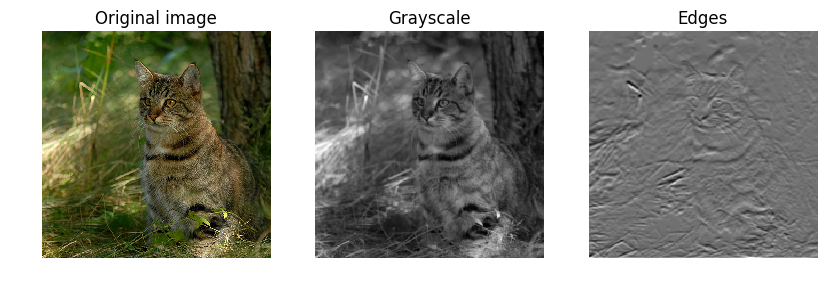

In [48]:
# forward sanity check
from scipy.misc import imread, imresize

cat = imread(DATASET_DIR+'imgsample/cat.jpg')

img_size = 200 # Make this smaller if it runs too slow
x = np.zeros((1, 3, img_size, img_size))
x[0, :, :, :] = imresize(cat, (img_size, img_size)).transpose((2, 0, 1))
print(x.shape)
# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv2d.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(1, 3, 1)
imshow_noax(cat, normalize=False)
plt.title('Original image')
plt.subplot(1, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(1, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.show()

In [51]:
from time import time
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv2d.forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv2d.forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv2d.forward(x, w, b, conv_param)[0], b, dout)

out, cache = conv2d.forward(x, w, b, conv_param)
dx, dw, db = conv2d.backward(dout, cache)

# Your errors should be around 1e-9'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.40482097654e-09
dw error:  2.26871429228e-10
db error:  3.1003302686e-11


<a id='SpatialBatchNormalization'></a>
### Spatial BatchNormalization
** Notation **   
$f$ : Index of the **f**eature dimension (size $H$ : **h**idden)  
$n$ : Index of the mi**n**i-batch data (size $N$ : **n**umber)  
$\mathcal{B}$ : variable on mini-batch  
$x$ : input with size of ($N$ : mini-batch, $H$ : height, $W$ : width, $C$ : channel)  
$x^{pad}$ : input with padding  
$P$ : padding size  
$S$ : stride  
The corresponding lower case for each size denotes the index of the constant.

#### In forward pass
\begin{align}
% mu
{}_{\mathcal{B}}\mu_c \leftarrow \frac{1}{NHW} \underset{npq}{\sum} x_{npqc} \\
% sigma
{}_{\mathcal{B}}\sigma_c^2 \leftarrow \frac{1}{NHW} \overset{N}{\underset{npq}{\sum}} \left(
x_{npqc} - {}_{\mathcal{B}}\mu_c \right)^2 \\
% xhat
\hat{x}_{npqc} = \frac{ x_{npqc} - {}_{\mathcal{B}}\mu_c }{\sqrt{{}_{\mathcal{B}}\sigma_c^2 + \epsilon}}\\
% y
y_{npqc} \leftarrow \gamma_c \hat{x}_{npqc} + \beta_c
\end{align}

#### In backward pass : calculate local gradient
\begin{eqnarray}
%dL/dxhat
\frac{\partial L}{\partial \hat{x}_{npqc}} &=& 
\underset{n'p'q'c'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c'}} \cdotp
\frac{\partial y_{n'p'q'c'}}{\partial \hat{x}_{npqc}} =
\underset{n'p'q'}{\sum}
\frac{\partial L}{\partial y_{n'p'q'c}} \gamma_c \\
%dL/dgamma
\frac{\partial L}{\partial \gamma_c} &=& 
\underset{n'p'q'c'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c'}} \cdotp
\frac{\partial y_{n'p'q'c'}}{\partial \gamma_c} = 
\underset{n'p'q'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c}} \hat{x}_{n'p'q'c} \\
%dL/dbeta
\frac{\partial L}{\partial {}_{\mathcal{B}}\beta_c} &=&  
\underset{n'p'q'c'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c'}} \cdotp 
\frac{\partial y_{n'p'q'c'}}{\partial {}_{\mathcal{B}}\beta_c} = \underset{n'p'q'c'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c'}} \cdotp \delta_{c'c} =
\underset{n'p'q'}{\sum} \frac{\partial L}{\partial y_{n'p'q'c}} \\
%dL/dsigma
\frac{\partial L}{\partial {}_{\mathcal{B}}\sigma_c^2} &=& 
\underset{npqc}{\sum} \frac{\partial L}{\partial \hat{x}_{npqc}} \cdotp
\frac{\partial \hat{x}_{npqc}}{\partial {}_{\mathcal{B}}\sigma_c^2} =
\underset{npq}{\sum} \frac{\partial L}{\partial \hat{x}_{npqc}} \cdotp
\frac{x_{npqc} - {}_{\mathcal{B}}\mu_c}{-2 \left( {}_{\mathcal{B}} \sigma_c^2 + \epsilon \right)^{-\frac{3}{2}}} \\
%dL/dmu
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_c} &=& 
\underset{n'p'q'c'}{\sum} \frac{\partial L}{\partial \hat{x}_{n'p'q'c'}} \cdotp 
\left(
\frac{\partial \hat{x}_{n'p'q'c'}}{\partial {}_{\mathcal{B}}\mu_c} +
\frac{\partial \hat{x}_{n'p'q'c'}}{\partial {}_{\mathcal{B}}\sigma_c^2} \cdotp
\frac{\partial {}_{\mathcal{B}}\sigma_c^2}{\partial {}_{\mathcal{B}}\mu_c}
\right)\\
&=& 
\underset{n'p'q'}{\sum} \frac{\partial L}{\partial \hat{x}_{n'p'q'c}} \cdotp
\left(- \frac{1}{\sqrt{{}_{\mathcal{B}}\sigma_c^2 + \epsilon }}\right)
+ \frac{\partial L}{\partial {}_{\mathcal{B}}\sigma_c^2} \cdotp
\frac{\underset{npq}{\sum}-2 \left( x_{npq}-{}_{\mathcal{B}}\mu_c\right) }{NHW} \\
%dL/dx
\frac{\partial L}{\partial x_{npqc}} &=& 
\left( 
\underset{n'p'q'c'}{\sum}
\frac{\partial L}{\partial \hat{x}_{n'p'q'c'}} \cdotp
\frac{\partial \hat{x}_{n'p'q'c'}}{\partial x_{npqc}} \right) +
\underset{c'}{\sum}
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_{c'}} \cdotp
\frac{\partial {}_{\mathcal{B}}\mu_{c'}}{\partial x_{npqc}} + 
\underset{c'}{\sum}
\frac{\partial L}{\partial {}_{\mathcal{B}} \sigma_{c'}^2} \cdotp
\frac{\partial {}_{\mathcal{B}}\sigma_{c'}^2}{\partial x_{npqc}} \\
&=&
\underset{n'p'q'}{\sum}
\frac{\partial L}{\partial \hat{x}_{n'p'q'c}} \cdotp
\frac{1}{\sqrt{{}_{\mathcal{B}}\sigma_c^2 + \epsilon}} + 
\frac{\partial L}{\partial {}_{\mathcal{B}}\mu_c} \cdotp
\frac{1}{NHW} +
\frac{\partial L}{{}_{\mathcal{B}}\sigma_c^2} \cdotp
\frac{2 \left( x_{npqc} - {}_{\mathcal{B}}\sigma_c^2 \right)}{NHW}
\end{eqnarray}


#### In backward pass : calculate through top
\begin{eqnarray}
%dL/dx
\frac{\partial L}{\partial x_{nklf}} &=& 
\underset{n'k'l'f'}{\sum} 
\frac{\partial L}{\partial y_{n'k'l'f'}} \cdotp \left[
\left( 
\underset{n''k''l''f''}{\sum}
\frac{\partial y_{n'k'l'f'}}{\partial \hat{x}_{n''k''l''f''}} \cdotp
\frac{\partial \hat{x}_{n''k''l''f''}}{\partial x_{nklf}} \right) +
\frac{\partial y_{n'k'l'f'}}{\partial {}_{\mathcal{B}}\mu_f} \cdotp
\frac{\partial {}_{\mathcal{B}}\mu_f}{\partial x_{mf}} + 
\frac{\partial y_{n'k'l'f'}}{\partial {}_{\mathcal{B}} \sigma_f^2} \cdotp
\frac{\partial {}_{\mathcal{B}}\sigma_f^2}{\partial x_{mf}} \right] \\
\end{eqnarray}

In [ ]:
class SpatialBatchNormalization(object):
    def forward(self, x, gamma, beta, bn_param):
        """
        Computes the forward pass for spatial batch normalization.

        Inputs:
        - x: Input data of shape (N, C, H, W)
        - gamma: Scale parameter, of shape (C,)
        - beta: Shift parameter, of shape (C,)
        - bn_param: Dictionary with the following keys:
          - mode: 'train' or 'test'; required
          - eps: Constant for numeric stability
          - momentum: Constant for running mean / variance. momentum=0 means that
            old information is discarded completely at every time step, while
            momentum=1 means that new information is never incorporated. The
            default of momentum=0.9 should work well in most situations.
          - running_mean: Array of shape (D,) giving running mean of features
          - running_var Array of shape (D,) giving running variance of features

        Returns a tuple of:
        - out: Output data, of shape (N, C, H, W)
        - cache: Values needed for the backward pass
        """
        out, cache = None, None

        ##########################################################################
        # TODO: Implement the forward pass for spatial batch normalization.         #
        #                                                                           #
        # HINT: You can implement spatial batch normalization using the vanilla     #
        # version of batch normalization defined above. Your implementation should  #
        # be very short; ours is less than five lines.                              #
        ##########################################################################

        N, C, H, W = x.shape
        mode = bn_param['mode']
        eps = bn_param.get('eps', 1e-5)
        momentum = bn_param.get('momentum', 0.9)

        running_mean = bn_param.get('running_mean', np.zeros(C, dtype=x.dtype))
        running_var = bn_param.get('running_var', np.zeros(C, dtype=x.dtype))

        if mode == 'train':
            # Step 1 , calcul the average for each channel
            mu = (1. / (N * H * W) * np.sum(x, axis=(0, 2, 3))).reshape(1, C, 1, 1)
            var = (1. / (N * H * W) * np.sum((x - mu)**2,
                                             axis=(0, 2, 3))).reshape(1, C, 1, 1)
            xhat = (x - mu) / (np.sqrt(eps + var))
            out = gamma.reshape(1, C, 1, 1) * xhat + beta.reshape(1, C, 1, 1)

            running_mean = momentum * running_mean + \
                (1.0 - momentum) * np.squeeze(mu)
            running_var = momentum * running_var + \
                (1.0 - momentum) * np.squeeze(var)

            cache = (mu, var, x, xhat, gamma, beta, bn_param)

            # Store the updated running means back into bn_param
            bn_param['running_mean'] = running_mean
            bn_param['running_var'] = running_var

        elif mode == 'test':
            mu = running_mean.reshape(1, C, 1, 1)
            var = running_var.reshape(1, C, 1, 1)

            xhat = (x - mu) / (np.sqrt(eps + var))
            out = gamma.reshape(1, C, 1, 1) * xhat + beta.reshape(1, C, 1, 1)
            cache = (mu, var, x, xhat, gamma, beta, bn_param)

        else:
            raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

        return out, cache


    def backward(self, dout, cache):
        """
        Computes the backward pass for spatial batch normalization.

        Inputs:
        - dout: Upstream derivatives, of shape (N, C, H, W)
        - cache: Values from the forward pass

        Returns a tuple of:
        - dx: Gradient with respect to inputs, of shape (N, C, H, W)
        - dgamma: Gradient with respect to scale parameter, of shape (C,)
        - dbeta: Gradient with respect to shift parameter, of shape (C,)
        """
        dx, dgamma, dbeta = None, None, None

        ##########################################################################
        # TODO: Implement the backward pass for spatial batch normalization.        #
        #                                                                           #
        # HINT: You can implement spatieal batch normalization using the vanilla     #
        # version of batch normalization defined above. Your implementation should  #
        # be very short; ours is less than five lines.                              #
        ##########################################################################

        mu, var, x, xhat, gamma, beta, bn_param = cache
        N, C, H, W = x.shape
        mode = bn_param['mode']
        eps = bn_param.get('eps', 1e-5)

        gamma = gamma.reshape(1, C, 1, 1)
        beta = beta.reshape(1, C, 1, 1)

        dbeta = np.sum(dout, axis=(0, 2, 3))
        dgamma = np.sum(dout * xhat, axis=(0, 2, 3))

        Nt = N * H * W
        dx = (1. / Nt) * gamma * (var + eps)**(-1. / 2.) * (
            Nt * dout
            - np.sum(dout, axis=(0, 2, 3)).reshape(1, C, 1, 1)
            - (x - mu) * (var + eps)**(-1.0) * np.sum(dout * (x - mu), axis=(0, 2, 3)).reshape(1, C, 1, 1))

        return dx, dgamma, dbeta

<a id='Pooling'></a>
### Pooling
**notation**  
$H_P$ : Height of pooling region  
$W_P$ : Width of pooling region  
The rest of the notations are the same with [convolution](#Convolutional Layer)

---
#### 1. Max-Pooling
#### In forward pass
\begin{eqnarray}
y_{n,k,l,c} &=&
\underset{0 \leq p \le H_P , 0 \leq q \le W_P}{max} x_{n,p+kS,q+lS,c} \\
&=&
x_{n,p_{max},q_{max},c}
\end{eqnarray}


#### In backward pass
\begin{eqnarray}
\frac{\partial L}{\partial x_{n'p'q'c'}} &=& 
\underset{n,k,l,c}{\sum} \frac{\partial L}{\partial y_{n,k,l,c}} \cdot
\frac{\partial y_{n,k,l,c}}{\partial x_{n',p',q',c'}} 
&=&
\underset{n,k,l,c}{\sum} \frac{\partial L}{\partial y_{n,k,l,c}}
\cdot
\delta_{n'n} \delta_{p'p_{max}} \delta_{q'q_{max}} \delta_{c'c}\\
&=&
\underset{k,l}{\sum} \frac{\partial L}{\partial y_{n',k,l,c'}} \cdot
\delta_{p'p_{max}} \delta_{q'q_{max}}
\end{eqnarray}

---
#### 2. Average-Pooling

---
#### 3. Unpooling


In [55]:
class MaxPooling(object):
    def forward(self, x, pool_param):
        """
        A naive implementation of the forward pass for a max pooling layer.

        Inputs:
        - x: Input data, of shape (N, C, H, W)
        - pool_param: dictionary with the following keys:
          - 'pool_height': The height of each pooling region
          - 'pool_width': The width of each pooling region
          - 'stride': The distance between adjacent pooling regions

        Returns a tuple of:
        - out: Output data (N,C,H1,W1)
        - cache: (x, pool_param)

        where H1 = (H-Hp)/S+1
        and W1 = (W-Wp)/S+1

        """

        ##########################################################################
        # TODO: Implement the max pooling forward pass                              #
        ##########################################################################

        Hp = pool_param['pool_height']
        Wp = pool_param['pool_width']
        S = pool_param['stride']
        N, C, H, W = x.shape
        H1 = (H - Hp) // S + 1
        W1 = (W - Wp) // S + 1

        out = np.zeros((N, C, H1, W1))
        for n in range(N):
            for c in range(C):
                for k in range(H1):
                    for l in range(W1):
                        out[n, c, k, l] = np.max(
                            x[n, c, k * S:k * S + Hp, l * S:l * S + Wp])

        cache = (x, pool_param)
        return out, cache


    def backward(self, dout, cache):
        """
        A naive implementation of the backward pass for a max pooling layer.

        Inputs:
        - dout: Upstream derivatives
        - cache: A tuple of (x, pool_param) as in the forward pass.

        Returns:
        - dx: Gradient with respect to x
        """
        dx = None
        ##########################################################################
        # TODO: Implement the max pooling backward pass                             #
        ##########################################################################
        x, pool_param = cache
        Hp = pool_param['pool_height']
        Wp = pool_param['pool_width']
        S = pool_param['stride']
        N, C, H, W = x.shape
        H1 = (H - Hp) // S + 1
        W1 = (W - Wp) // S + 1

        dx = np.zeros((N, C, H, W))
        for nprime in range(N):
            for cprime in range(C):
                for k in range(H1):
                    for l in range(W1):
                        x_pooling = x[nprime, cprime, k *
                                      S:k * S + Hp, l * S:l * S + Wp]
                        maxi = np.max(x_pooling)
                        x_mask = x_pooling == maxi
                        dx[nprime, cprime, k * S:k * S + Hp, l * S:l *
                            S + Wp] += dout[nprime, cprime, k, l] * x_mask
        return dx

    def max_pool_forward_fast(x, pool_param):
        """
        A fast implementation of the forward pass for a max pooling layer.

        This chooses between the reshape method and the im2col method. If the pooling
        regions are square and tile the input image, then we can use the reshape
        method which is very fast. Otherwise we fall back on the im2col method, which
        is not much faster than the naive method.
        """
        N, C, H, W = x.shape
        pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']

        same_size = pool_height == pool_width == stride
        tiles = H % pool_height == 0 and W % pool_width == 0
        if same_size and tiles:
            out, reshape_cache = max_pool_forward_reshape(x, pool_param)
            cache = ('reshape', reshape_cache)
        else:
            out, im2col_cache = max_pool_forward_im2col(x, pool_param)
            cache = ('im2col', im2col_cache)
        return out, cache


    def max_pool_backward_fast(dout, cache):
        """
        A fast implementation of the backward pass for a max pooling layer.

        This switches between the reshape method an the im2col method depending on
        which method was used to generate the cache.
        """
        method, real_cache = cache
        if method == 'reshape':
            return max_pool_backward_reshape(dout, real_cache)
        elif method == 'im2col':
            return max_pool_backward_im2col(dout, real_cache)
        else:
            raise ValueError('Unrecognized method "%s"' % method)


    def max_pool_forward_reshape(x, pool_param):
        """
        A fast implementation of the forward pass for the max pooling layer that uses
        some clever reshaping.

        This can only be used for square pooling regions that tile the input.
        """
        N, C, H, W = x.shape
        pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']
        assert pool_height == pool_width == stride, 'Invalid pool params'
        assert H % pool_height == 0
        assert W % pool_height == 0
        x_reshaped = x.reshape(N, C, H / pool_height, pool_height,
                                                     W / pool_width, pool_width)
        out = x_reshaped.max(axis=3).max(axis=4)

        cache = (x, x_reshaped, out)
        return out, cache


    def max_pool_backward_reshape(dout, cache):
        """
        A fast implementation of the backward pass for the max pooling layer that
        uses some clever broadcasting and reshaping.

        This can only be used if the forward pass was computed using
        max_pool_forward_reshape.

        NOTE: If there are multiple argmaxes, this method will assign gradient to
        ALL argmax elements of the input rather than picking one. In this case the
        gradient will actually be incorrect. However this is unlikely to occur in
        practice, so it shouldn't matter much. One possible solution is to split the
        upstream gradient equally among all argmax elements; this should result in a
        valid subgradient. You can make this happen by uncommenting the line below;
        however this results in a significant performance penalty (about 40% slower)
        and is unlikely to matter in practice so we don't do it.
        """
        x, x_reshaped, out = cache

        dx_reshaped = np.zeros_like(x_reshaped)
        out_newaxis = out[:, :, :, np.newaxis, :, np.newaxis]
        mask = (x_reshaped == out_newaxis)
        dout_newaxis = dout[:, :, :, np.newaxis, :, np.newaxis]
        dout_broadcast, _ = np.broadcast_arrays(dout_newaxis, dx_reshaped)
        dx_reshaped[mask] = dout_broadcast[mask]
        dx_reshaped /= np.sum(mask, axis=(3, 5), keepdims=True)
        dx = dx_reshaped.reshape(x.shape)

        return dx


    def max_pool_forward_im2col(x, pool_param):
        """
        An implementation of the forward pass for max pooling based on im2col.

        This isn't much faster than the naive version, so it should be avoided if
        possible.
        """
        N, C, H, W = x.shape
        pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']

        assert (H - pool_height) % stride == 0, 'Invalid height'
        assert (W - pool_width) % stride == 0, 'Invalid width'

        out_height = (H - pool_height) / stride + 1
        out_width = (W - pool_width) / stride + 1

        x_split = x.reshape(N * C, 1, H, W)
        x_cols = im2col(x_split, pool_height, pool_width, padding=0, stride=stride)
        x_cols_argmax = np.argmax(x_cols, axis=0)
        x_cols_max = x_cols[x_cols_argmax, np.arange(x_cols.shape[1])]
        out = x_cols_max.reshape(out_height, out_width, N, C).transpose(2, 3, 0, 1)

        cache = (x, x_cols, x_cols_argmax, pool_param)
        return out, cache


    def max_pool_backward_im2col(dout, cache):
        """
        An implementation of the backward pass for max pooling based on im2col.

        This isn't much faster than the naive version, so it should be avoided if
        possible.
        """
        x, x_cols, x_cols_argmax, pool_param = cache
        N, C, H, W = x.shape
        pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']

        dout_reshaped = dout.transpose(2, 3, 0, 1).flatten()
        dx_cols = np.zeros_like(x_cols)
        dx_cols[x_cols_argmax, np.arange(dx_cols.shape[1])] = dout_reshaped
        dx = col2im_indices(dx_cols, (N * C, 1, H, W), pool_height, pool_width,
                                padding=0, stride=stride)
        dx = dx.reshape(x.shape)

        return dx

#### maxpooling sanity check

In [59]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

maxpool = MaxPooling()

out, _ = maxpool.forward(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: maxpool.forward(x, pool_param)[0], x, dout)

out, cache = maxpool.forward(x, pool_param)
dx = maxpool.backward(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08
Testing max_pool_backward_naive function:
dx error:  3.27564109769e-12


<a id='Dropout'></a>
### Dropout

In [ ]:
class Dropout(object):
    def forward(self, x, dropout_param):
        """
        Performs the forward pass for (inverted) dropout.

        Inputs:
        - x: Input data, of any shape
        - dropout_param: A dictionary with the following keys:
          - p: Dropout parameter. We drop each neuron output with probability p.
          - mode: 'test' or 'train'. If the mode is train, then perform dropout;
            if the mode is test, then just return the input.
          - seed: Seed for the random number generator. Passing seed makes this
            function deterministic, which is needed for gradient checking but not in
            real networks.

        Outputs:
        - out: Array of the same shape as x.
        - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
          mask that was used to multiply the input; in test mode, mask is None.
        """

        p, mode = dropout_param['p'], dropout_param['mode']
        if 'seed' in dropout_param:
            np.random.seed(dropout_param['seed'])

        mask = None
        out = None

        if mode == 'train':
            #######################################################################
            # TODO: Implement the training phase forward pass for inverted dropout.   #
            # Store the dropout mask in the mask variable.                            #
            #######################################################################
            mask = (np.random.rand(*x.shape) < p) / p
            out = x * mask

        elif mode == 'test':
            ###################################################################
            # TODO: Implement the test phase forward pass for inverted dropout.       #
            ###################################################################
            mask = None
            out = x

        cache = (dropout_param, mask)
        out = out.astype(x.dtype, copy=False)

        return out, cache

    def backward(self, dout, cache):
        """
        Perform the backward pass for (inverted) dropout.

        Inputs:
        - dout: Upstream derivatives, of any shape
        - cache: (dropout_param, mask) from dropout_forward.
        """
        dropout_param, mask = cache
        mode = dropout_param['mode']

        dx = None
        if mode == 'train':
            #######################################################################
            # TODO: Implement the training phase backward pass for inverted dropout.  #
            #######################################################################
            dx = dout * mask

        elif mode == 'test':
            dx = dout
        return dx

<a id='RNN'></a>
## RNN

In [ ]:
# An Empirical Exploration of Recurrent Network Architectures
# http://jmlr.org/proceedings/papers/v37/jozefowicz15.pdf
# based on cs231n lec10
# exploding gradient -> clip
# vanishing gradient -> LSTM, GRU(without cell state)
class LSTM():
    H = 5 # dim of hidden state
    T = 50 # the num of time steps
    Whh = np.random.randn(H, H)
    
    # forward pass of an RNN
    hs = {}
    ss = {}
    hs[-1] = np.random.randn(H)
    for t in range(T):
        ss[t] = np.dot(Whh, hs[t-1]) # 
        hs[t] = np.maximum(0, ss[t]) # relu
        
    # backward pass of the RNN
    dhs = {}
    dss = {}
    dhs[T-1] = np.random.randn(H) # start with random radient
    for t in reversed(range(T)):
        dss[t] = (hs[t] > 0) * dhs[t] # backprop through the nonlinearity
        dhs[t-1] = np.dot(Whh.T, dss[t]) # backprop into prev hidden state
        
class GRU():
    """
        Learning Phrase Representations 
        using RNN Encoder-Decoder for Statistical Machine Translation
        https://arxiv.org/abs/1406.1078
    """

In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np
# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0

    # forward pass
    for t in xrange(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(xrange(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in xrange(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print '----\n %s \n----' % (txt, )

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
    
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
n += 1 # iteration counter 

<a id='Optimization and update scheme'></a>
## 4. Optimization and update scheme
 cs231n lec5  

In [ ]:
class optimization_lab():
    """
    SGD, Momentum, Nestrov Momentum, Adagrad, Adadelta, RMSprop, Adam

    This file implements various first-order update rules that are commonly used for
    training neural networks. Each update rule accepts current weights and the
    gradient of the loss with respect to those weights and produces the next set of
    weights. Each update rule has the same interface:

    def update(w, dw, config=None):

    Inputs:
      - w: A numpy array giving the current weights.
      - dw: A numpy array of the same shape as w giving the gradient of the
        loss with respect to w.
      - config: A dictionary containing hyperparameter values such as learning rate,
        momentum, etc. If the update rule requires caching values over many
        iterations, then config will also hold these cached values.

    Returns:
      - next_w: The next point after the update.
      - config: The config dictionary to be passed to the next iteration of the
        update rule.

    NOTE: For most update rules, the default learning rate will probably not perform
    well; however the default values of the other hyperparameters should work well
    for a variety of different problems.

    For efficiency, update rules may perform in-place updates, mutating w and
    setting next_w equal to w.
    """
    def sgd(w, dw, config=None):
        """
        Performs vanilla stochastic gradient descent.

        config format:
        - learning_rate: Scalar learning rate.
        """
        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-2)

        w -= config['learning_rate'] * dw
        return w, config

    def sgd_momentum(w, dw, config=None):
        """
        Performs stochastic gradient descent with momentum.

        config format:
        - learning_rate: Scalar learning rate.
        - momentum: Scalar between 0 and 1 giving the momentum value.
          Setting momentum = 0 reduces to sgd.
        - velocity: A numpy array of the same shape as w and dw used to store a moving
          average of the gradients.

        """

        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('momentum', 0.9)
        v = config.get('velocity', np.zeros_like(w))
        next_v = config['momentum'] * v - config['learning_rate'] * dw
        next_w = w + next_v

        ##########################################################################
        # TODO: Implement the momentum update formula. Store the updated value in   #
        # the next_w variable. You should also use and update the velocity v.       #
        ##########################################################################
        pass
        ##########################################################################
        #                             END OF YOUR CODE                              #
        ##########################################################################
        config['velocity'] = next_v

        return next_w, config
    
    # TODO:
    def nestrov_momentum(x, dx, mu, learning_rate):
        v_prev = v
        v = mu * v -learning_rate * dx
        return x += v
    
    def adagrad():
        return None

    def adadelta():
        return None    
    
    def rmsprop(x, dx, config=None):
        """
        Uses the RMSProp update rule, which uses a moving average of squared gradient
        values to set adaptive per-parameter learning rates.

        config format:
        - learning_rate: Scalar learning rate.
        - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
          gradient cache.
        - epsilon: Small scalar used for smoothing to avoid dividing by zero.
        - cache: Moving average of second moments of gradients.
        """

        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('decay_rate', 0.99)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('cache', np.zeros_like(x))

        config['cache'] = config['cache'] * config['decay_rate'] +\
            (1 - config['decay_rate']) * dx**2
        next_x = x - config['learning_rate'] * dx / (np.sqrt(config['cache']
                                                             + config['epsilon']))

        ##########################################################################
        # TODO: Implement the RMSprop update formula, storing the next value of x   #
        # in the next_x variable. Don't forget to update cache value stored in      #
        # config['cache'].                                                          #
        ##########################################################################
        pass
        ##########################################################################
        #                             END OF YOUR CODE                              #
        ##########################################################################

        return next_x, config


    def adam(x, dx, config=None):
        """
        Uses the Adam update rule, which incorporates moving averages of both the
        gradient and its square and a bias correction term.

        config format:
        - learning_rate: Scalar learning rate.
        - beta1: Decay rate for moving average of first moment of gradient.
        - beta2: Decay rate for moving average of second moment of gradient.
        - epsilon: Small scalar used for smoothing to avoid dividing by zero.
        - m: Moving average of gradient.
        - v: Moving average of squared gradient.
        - t: Iteration number.
        """
        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-3)
        config.setdefault('beta1', 0.9)
        config.setdefault('beta2', 0.999)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('m', np.zeros_like(x))
        config.setdefault('v', np.zeros_like(x))
        config.setdefault('t', 0)

        learning_rate = config['learning_rate']
        beta1 = config['beta1']
        beta2 = config['beta2']
        epsilon = config['epsilon']

        # Value after the update
        config['t'] += 1
        config['m'] = beta1 * config['m'] + (1 - beta1) * dx
        config['v'] = beta2 * config['v'] + (1 - beta2) * dx**2
        mt_hat = config['m'] / (1 - (beta1)**config['t'])
        vt_hat = config['v'] / (1 - (beta2)**config['t'])
        next_x = x - learning_rate * mt_hat / (np.sqrt(vt_hat + epsilon))

        ##########################################################################
        # TODO: Implement the Adam update formula, storing the next value of x in   #
        # the next_x variable. Don't forget to update the m, v, and t variables     #
        # stored in config.                                                         #
        ##########################################################################
        pass
        ##########################################################################
        #                             END OF YOUR CODE                              #
        ##########################################################################

        return next_x, config
    
    
    def evaluate_gradient():
        """ numerical gradient """
        return

    def run():
            while True:
                weights_grad = evaluate_gradient(loss_fn, data, weights)
                weights += -step_size + weights_grad
        return


<a id='ConvNet Model Breakdown'></a>
## 5. ConvNet Model Breakdown
    - Inception Module
    - ResNet Module

#### Inception-v4 module

["Inception-v4, Inception-ResNet and
the Impact of Residual Connections on Learning", Szegedy et al, arXiv, (2016)](https://arxiv.org/pdf/1602.07261.pdf)